In [1]:
import time
import numpy as np
import joblib
import pandas as pd
import seaborn as sb
import truvari
import matplotlib.pyplot as plt
sb.set()
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
def show_values_on_bars(axs, fmt='{:.2f}', buff=0, box=True, size=15):
    """ 
        Given a barchart (seaborn or matplotlib), add values on top of bars
         c/o https://stackoverflow.com/a/51535326 
    """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + buff
            value = fmt.format(p.get_height())
            t = ax.text(_x, _y, value, ha="center", size=size)
            if box:
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
features = ['VARLEN', 'GT', 'GQ', 'DP', 'AD_r', 'AD_a', 'US_r', 'US_a', 
            'DS_r', 'DS_a', 'UC_r', 'UC_a', 'DC_r', 'DC_a', 'UDC_r', 
            'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 'DCC_a', 
            'UMO_r', 'UMO_a', 'DMO_r', 'DMO_a', 'NR_r', 'NR_a', 'MO_r', 'MO_a', 
            'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 'EC_r', 'EC_a', 
            'PL_ref', 'PL_het', 'PL_hom',
            'UXO_r', 'UXO_a', 'DXO_r', 'DXO_a', 'XO_r', 'XO_a']
trans_features = ["AD_r", "AD_a", "UC_r", "UC_a", "DC_a", "DC_r", 'UDC_r', 'UDC_a', 'UCC_r', 'UCC_a', 'DDC_r', 'DDC_a', 'DCC_r', 'DCC_a', 'XC_r', 'XC_a', 'AC_r', 'AC_a', 'MC_r', 'MC_a', 'EC_r', 'EC_a']
keep_features = [_ for _ in features if _ not in trans_features] + ["RC"]
labels = ["GT_answer"]

# I want to see what happens when I transform the _r / _a numbers into all ratios of one another
def transform(data):
    ret = pd.DataFrame()
    union = set()
    others = []
    for i in trans_features:
        if i.endswith('_r') or i.endswith("_a"):
            union.add(i.split('_')[0])
        else:
            ret[i] = data[i]
    for i in union:
        denom = data[i + '_a'] + data[i + '_r']
        alt = data[i + '_a'] / denom
        ref = data[i + '_r'] / denom
        ret[i] = alt - ref
    for i in keep_features:
        ret[i] = data[i]
    # No coverage is assumed to be -1
    to_return = norm_rl(ret.fillna(-1))
    #.apply(norm_nr, axis=1)
    return to_return

def norm_rl(df):
    """
    Normalizes read length dependent features
    """
    rl_feat = ["US_r", "US_a", "DS_a", "DS_r", "UXO_r", "UXO_a", "DXO_r", "DXO_a", "UMO_r", "UMO_a", "DMO_r", "DMO_a", "MO_r", "MO_a", "XO_r", "XO_a"]
    rl = df['MO_r'].max()
    df[rl_feat] = df[rl_feat] / rl
    return df

def set_size(x):
    # SET VARLEN to the appropriate sign
    return x["VARLEN"] if x["var_type"] == "INS" else -x["VARLEN"]

def norm_nr(line):
    if line["VARLEN"] < 0:
        line["NR_r"] = line["NR_r"] / abs(line["VARLEN"])
    else:
        line["NR_a"] = line["NR_a"] / line["VARLEN"]
    return line

In [141]:
def make_dataframe(base_variants, coverage_df, no_neigh=True):
    """
    Given a vcf, the base variants overwhich we're training, and the coverage df
    Build the full data-frame with their correct label
    If no_neigh, only return rows without neighbors
    returns classification_df, labels
    """
    base = joblib.load(base_variants)
    cov_df = joblib.load(coverage_df)
    cov_df = cov_df.set_index("key")
    
    if no_neigh:
        base = base[base["NumNeighbors"] == 0]
    data = cov_df.loc[cov_df.index.isin(base.index)]
    labels = base["GT"].apply(lambda x: truvari.get_gt(x).value)
    data = data.join(labels, rsuffix="_label")
    return data

def rank_feature_importance(forest, features):
    """
    Given a created classifier pipeline (where step[1] is the RFC), and the feature names
    make a plot of the feature importance based on mean decrease in impurity
    """
    start_time = time.time()
    clsf = forest.steps[1][1]
    importances = clsf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clsf.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=features)
    forest_importances.sort_values(inplace=True, ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def build_model(data, label):
    """
    Build and return pipeline with StandardScaler and RFC
    transform(keep, trans_features, keep_features), answer
    """
    rfc = RandomForestClassifier(random_state=1392,
                                 n_jobs=-1, n_estimators=500,
                                 bootstrap=True, max_features="sqrt", 
                                 max_depth=30)
    clf = make_pipeline(StandardScaler(), rfc)
    return clf.fit(data, label)

def predict_gt(model, data):
    t_data = transform(data)
    gts = pd.Series(model.predict(t_data), name="predict")#.apply(lambda x: truvari.GT(x).name)
    pls = pd.DataFrame(model.predict_proba(t_data), columns=["REF", "HET", "HOM"])
    def rounder(d):
        r = -10 * np.log10(d)
        r = r.replace(-0, 0).replace([np.inf], 99).round().astype(int)
        return r
    pls['PL_ref'] = rounder(pls["REF"])
    pls['PL_het'] = rounder(pls['HET'])
    pls['PL_hom'] = rounder(pls['HOM'])
    pls["GQ"] = pls[["PL_ref", "PL_het", "PL_hom"]].min(axis=1)
    ret = pls.join(gts)
    ret.index = t_data.index
    #.apply(lambda x: truvari.GT(x).name))#test_base["GT"])
    return ret.join(data["GT_label"])

def make_roc_curves(results, title_label):
    """
    """
    for tys, label in [(["DEL", "INS"], "TOT"), (["INS"], "INS"), (["DEL"], "DEL")]:
        res = results[results["svtype"].isin(tys)]
        fpr, tpr, thresholds = roc_curve(res["is_correct"], res[["REF", "HET", "HOM"]].max(axis=1))
        auc = roc_auc_score(res["is_correct"], res[["REF", "HET", "HOM"]].max(axis=1))
        accuracy = res["is_correct"].mean()
        plt.plot(fpr, tpr, label="%s (%.2f%%, %.2f)" % (label, accuracy * 100, auc))
    plt.title(f"{title_label} ROC curves")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(title="SV (ACC, AUC)")
    hide = plt.show()

def summarize_perf_by_attribs(results):
    rows = []
    for vals, dat in results.groupby(["svtype", "GT_label"]):
        dat = dat.groupby(["is_correct"]).count()
        tp = dat.loc[True]["REF"]
        fp = dat.loc[False]["REF"]
        rows.append([vals[0], truvari.GT(vals[1]).name, tp / (tp + fp)])
    summary = pd.DataFrame(rows, columns=["svtype", "GT", "pct_correct"])

    p = sb.barplot(data=summary, x="GT", y="pct_correct", hue="svtype")
    p.set(title="Performance by Type/GT", ylim=(0,1.1), xlabel="Label GT")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    show_values_on_bars(p, box=False)
    return summary

def make_gt_heatmap(results):
    rows = np.zeros((3,3))
    for label, dat in results.groupby(["GT_label", "predict"]):
        cnt = len(dat)
        rows[label[0]][label[1]] = cnt
    rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
    pred_rows = rows / rows.sum(axis=0)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    label_rows = rows.T / rows.sum(axis=1)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(label_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()

In [5]:
train_data = make_dataframe("/raid/home/english/science/english/gt_checks/results/HG00096.base.sv.jl",
                            "/raid/home/english/science/english/gt_checks/results/HG00096.chr1.df.jl")

In [6]:
model = build_model(transform(train_data), train_data["GT_label"])

In [7]:
print("Training Label Freq")
train_data["GT_label"].apply(truvari.GT).value_counts()

Training Label Freq


GT.REF    2435
GT.HET     304
GT.HOM     264
Name: GT_label, dtype: int64

Elapsed time to compute the importances: 0.347 seconds


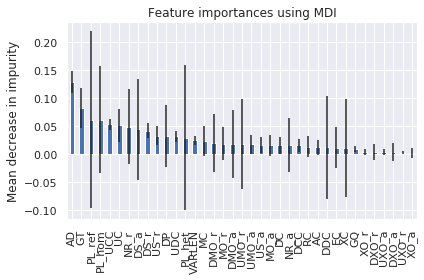

In [149]:
rank_feature_importance(model, transform(train_data).columns)

In [143]:
test_data = make_dataframe("/raid/home/english/science/english/gt_checks/sample2/NA19238.base.sv.jl",
                           "/raid/home/english/science/english/gt_checks/sample2/grch38.chr2.df.jl",
                          )#no_neigh=False)

In [144]:
# Predict the GT for the test data and fill in extra annotation
results = predict_gt(model, test_data)
results["is_correct"] = results["predict"] == results["GT_label"]
svtype = test_data["var_type"]
svtype.name = "svtype"
results = results.join(svtype)

/raid/home/english/pyve/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


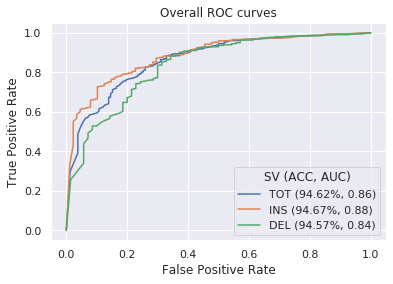

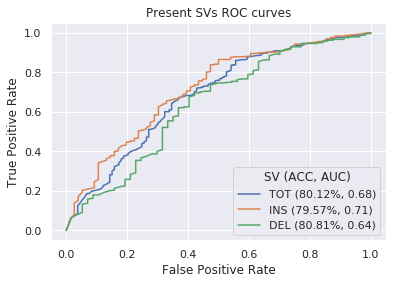

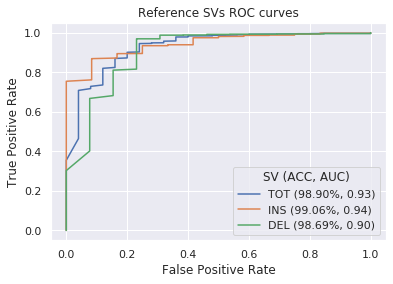

In [145]:
make_roc_curves(results, "Overall")
make_roc_curves(results[results["GT_label"] != 0], "Present SVs")
make_roc_curves(results[results["GT_label"] == 0], "Reference SVs")

  svtype   GT  pct_correct
0    DEL  REF     0.986882
1    DEL  HET     0.754098
2    DEL  HOM     0.894737
3    INS  REF     0.990618
4    INS  HET     0.768595
5    INS  HOM     0.846154


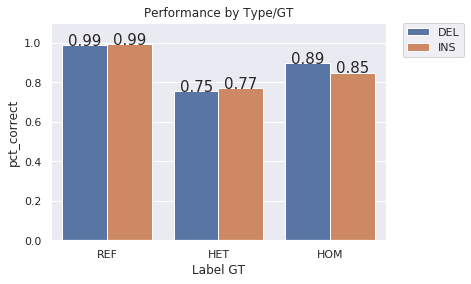

In [146]:
summary = summarize_perf_by_attribs(results)
print(summary)

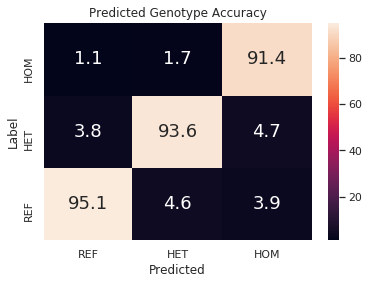

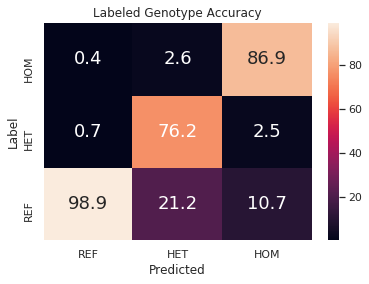

In [148]:
make_gt_heatmap(results)